<a href="https://colab.research.google.com/github/Lorandoff/Data-Science/blob/2/Tariff_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tariff recommendation

At your disposal is data on the behavior of customers who have already switched to these tariffs. You need to build a model for the classification problem that will select the appropriate rate.

## Open and examine the file

In [ ]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
data = pd.read_csv("datasets/users_behavior.csv")
#Round the values in the columns and convert to int type, this is necessary, because with float, with one of the hyperparameters
#DecisionTreeClassifier gives an error
for i in ["calls","minutes","messages","mb_used"]:
    data[i] = round(data[i]).astype("int")

    
#Conclusions are needed to get the range of values for functions
print(data["calls"].min(), data["calls"].max())
print(data["minutes"].min(), data["minutes"].max())
print(data["messages"].min(), data["messages"].max())
print(data["mb_used"].min(), data["mb_used"].max())
#Why these functions are needed is explained in the cell below
def category(row):
    calls = row
    if calls >=0 and calls <= 60:
        return 0
    if calls > 60 and calls <= 120:
        return 1
    if calls > 120 and calls <= 180:
        return 2
    if calls > 180:
        return 3
def category_min(row):
    minutes = row
    if minutes >= 0 and minutes <= 400:
        return 0
    if minutes > 400 and minutes <= 800:
        return 1
    if minutes > 800 and minutes <= 1200:
        return 2
    if minutes > 1200:
        return 3
def category_mes(row):
    messages = row
    if messages >= 0 and messages <= 60:
        return 0
    if messages > 60 and messages <= 120:
        return 1
    if messages > 120 and messages <= 180:
        return 2
    if messages > 180:
        return 3
def category_mb(row):
    mb_used = row
    if mb_used >= 0 and mb_used <= 12500:
        return 0
    if mb_used > 12500 and mb_used <= 25000:
        return 1
    if mb_used > 25000 and mb_used <= 37500:
        return 2
    if mb_used > 37500:
        return 3
columns = ["calls","minutes","messages","mb_used"]
data = data.drop(["calls"], axis = 1)
display(data)
#data["calls"] = data["calls"].apply(category)
#data["messages"] = data["messages"].apply(category_mes)
#data["minutes"] = data["minutes"].apply(category_min)
#data["mb_used"] = data["mb_used"].apply(category_mb)    
display(data)
display(data)

0 244
0 1632
0 224
0 49746


,minutes,messages,mb_used,is_ultra
0,312,83,19915,0
1,517,56,22697,0
2,468,86,21060,0
3,746,81,8437,1
4,419,1,14503,0
...,...,...,...,...
3209,911,20,35125,1
3210,190,0,3276,0
3211,634,70,13974,0
3212,462,90,31240,0


,minutes,messages,mb_used,is_ultra
0,312,83,19915,0
1,517,56,22697,0
2,468,86,21060,0
3,746,81,8437,1
4,419,1,14503,0
...,...,...,...,...
3209,911,20,35125,1
3210,190,0,3276,0
3211,634,70,13974,0
3212,462,90,31240,0


,minutes,messages,mb_used,is_ultra
0,312,83,19915,0
1,517,56,22697,0
2,468,86,21060,0
3,746,81,8437,1
4,419,1,14503,0
...,...,...,...,...
3209,911,20,35125,1
3210,190,0,3276,0
3211,634,70,13974,0
3212,462,90,31240,0


Each object in the data set is information about the behavior of one user per month. Known:


calls — number of calls,


minutes — total duration of calls in minutes,


messages — number of sms messages,


mb_used - Internet traffic used in Mb,


is_ultra - what tariff did you use during the month ("Ultra" - 1, "Smart" - 0).


The functions were written following a recommendation from an article that said that categorizing the data in the sample could improve the accuracy of the model, and it may work, but in this case, it only worsened the accuracy, so it was decided to just leave these functions and not override them.

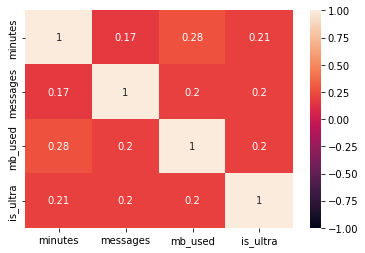

In [ ]:
sns.heatmap(data.corr(), vmin = -1, vmax = 1, annot = True)
plt.show()
fig = px.scatter(data, y = "mb_used", x = "messages", color = "minutes")
fig.show(renderer = "colab")

## Let's break the data into samples

We split the general sample into training (data_train), test (data_test), after which we split the test sample into test and validation (data_valid). We divide the training and validation sets into the main features and the desired feature, and remove the desired feature from the test set.

In [ ]:
data_train,data_test = train_test_split(data, test_size = 0.4, random_state = 12345)
data_test,data_valid = train_test_split(data_test, test_size = 0.5, random_state = 12345)
features_train = data_train.drop(["is_ultra"], axis = 1)
target_train = data_train["is_ultra"]

features_test = data_test.drop(["is_ultra"], axis = 1)

features_valid = data_valid.drop(["is_ultra"], axis = 1)
target_valid = data_valid["is_ultra"]
#features_train,features_valid,target_train,target_valid = train_test_split(features, target, test_size = 0.3, random_state = 12345)

## Model exploration

Let's explore three models: DecisionTreeClassifier, RandomForestClassifier, LogisticRegression.


Let's start with the DecisionTreeClassifier. With help, we will select the best parameter values ​​for the best accuracy of the model (the step value is 50, due to the need to check the performance of the code, when I tested the accuracy of the model, the step value was 1-3).

In [ ]:
#DecisionTreeClassifier
best_result = 0
best_model = None
best_max_depth = 0
best_min_samples_leaf = 0
best_min_samples_split = 0
best_max_leaf_nodes = 0
for i in range(2,100,50):
    for y in range(2,100,50):
        for e in range(2,100,50):
            for m in range(2,100,50):
                model = DecisionTreeClassifier(max_depth = i, min_samples_leaf = y, min_samples_split = e, max_leaf_nodes = m, 
                                              random_state = 12345)
                model.fit(features_train,target_train)
                prediction = model.predict(features_valid)
                result = accuracy_score(target_valid,prediction)
                if result > best_result:
                    best_result = result
                    best_model = model
                    best_max_depth = i
                    best_min_samples_leaf = y
                    best_min_samples_split = e
                    best_max_leaf_nodes = m
print("Best Model:", result,"Best max depth:", best_max_depth,"best min_samples_leaf:", best_min_samples_leaf,
      "Best min_samples_split:", best_min_samples_split,"best max_leaf_nodes",best_max_leaf_nodes )

Best Model: 0.7807153965785381 Best max depth: 52 best min_samples_leaf: 2 Best min_samples_split: 2 best max_leaf_nodes 52


As a result, the maximum accuracy of the model after all the tests that I conducted was 78.5 percent (predictions were made immediately on the validation set). Not a bad result, given the speed of model learning.

Next, let's explore the RandomForestClassifier. Here I explored a lot more hyperparameters, unfortunately not all of them improved the model, so I had to remove them (partly because with a huge number of hyperparameters and a step of 5, all combinations of the model were trained for more than 14 hours), in the end we have a better result in comparison with the previous model equal to 80.5 percent.

In [ ]:
#RandomForestClassifier
best_result = 0
best_model = None
best_max_depth = 0
best_n_estimators = 0
best_min_samples_split = 0
best_min_samples_leaf = 0
best_max_leaf_nodes = 0
best_class_weight = None
for i in range(2,100,50):
    for y in range(2,100,50):
        for e in range(2,100,50):
            for m in range(2,100,50):
                model = RandomForestClassifier(max_depth = i, n_estimators = y, min_samples_split = e, min_samples_leaf = m,
                                                      random_state = 12345)
                model.fit(features_train, target_train)
                prediction = model.predict(features_valid)
                result = accuracy_score(target_valid,prediction)
                if result > best_result:
                    best_result = result
                    best_model = model
                    best_max_depth = i
                    best_n_estimators = y
                    best_min_samples_split = e
                    best_min_samples_leaf = m
print("Best Model:", best_result, "Best max depth:", best_max_depth, "Best n_estimators:", best_n_estimators,
      "Best min_samples_split:", best_min_samples_split, "best min_samples_leaf:", best_min_samples_leaf, 
     "Best max_leaf_nodes:", best_max_leaf_nodes, "Best class_weight:", best_class_weight)

Best Model: 0.8040435458786936 Best max depth: 52 Best n_estimators: 2 Best min_samples_split: 52 best min_samples_leaf: 2 Best max_leaf_nodes: 0 Best class_weight: None


While I was waiting for the execution of the previous cell and was perplexed by the time spent on it, I was looking for ways to speed up this process, and, fortunately, I found an article on Habré, where a person explains in detail how to find the best combination of hyperparameters (in that article, by the way, the model with default hyperparameters).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
model = RandomForestClassifier()
model.fit(features_train,target_train)

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 1000)]
max_features = ['log2', 'sqrt', "auto"]
max_depth = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 1000)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 1000, num = 100)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 1000, num = 100)]
max_leaf_nodes = [int(x) for x in np.linspace(start = 2, stop = 1000, num = 100)]
#min_impurity_decrease = [x for x in range(0, 100, 7.5)]
max_samples = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 100)]
class_weight = ["balanced","balanced_subsample"]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
                "max_leaf_nodes" : max_leaf_nodes}
rs = RandomizedSearchCV(model, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(features_train, target_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'max_features': ['log2', 'sqrt',
                                                         'auto'],
                                        'max_leaf_nodes': [2, 12, 22, 32, 42,
                                                           52, 62, 72, 82, 92,
                                                           102, 112, 122, 133,
                                                           143, 153

In [ ]:
#Summarize the results in a table, sorting by model accuracy and deleting unnecessary columns
rs_df = pd.DataFrame(rs.cv_results_).sort_values("rank_test_score").reset_index(drop = True)
rs_df = rs_df.drop([
    "mean_fit_time",
    "std_fit_time",
    "mean_score_time",
    "std_score_time",
    "params",
    "split0_test_score",
    "split1_test_score",
    "split2_test_score",
    "std_test_score"],
    axis = 1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_leaf_nodes,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,271,455,22,717,auto,174,True,0.804983,1
1,863,42,12,374,auto,997,True,0.804981,2
2,604,919,22,778,sqrt,528,False,0.801350,3
3,168,415,62,536,sqrt,244,False,0.787852,4
4,973,596,62,344,auto,913,True,0.786827,5
5,674,838,92,163,sqrt,462,False,0.783712,6
6,609,586,122,818,log2,83,False,0.782679,7
7,702,274,112,637,log2,270,False,0.782678,8
8,819,627,82,778,auto,133,False,0.782674,9
9,261,385,92,949,sqrt,840,False,0.776962,10


In [ ]:
#Pass the best combination of model hyperparameters
model = RandomForestClassifier(criterion = "gini", bootstrap = True, n_estimators = 863, max_features = "auto", max_depth = 997, min_samples_leaf = 12, min_samples_split = 42, 
                               max_leaf_nodes = 374, random_state = 12345)
model.fit(features_train,target_train)
predictions = model.predict(features_train)
print("Model accuracy on test selection:", accuracy_score(target_train,predictions))

Model accuracy on test selection: 0.8298755186721992


The last thing to check is the LogisticRegression. It has so many hyperparameters, and in general, I found it gives the best accuracy with this sample with default hyperparameters. The accuracy itself leaves much to be desired, only 74 percent, but quickly)

In [ ]:
#LogisticRegression
best_result = 0
best_model = None
best_intercept_scaling = 0
best_max_iter = 0
for i in range(1,300,10):
    for y in range(100,400,10):
        model1 = LogisticRegression(solver = "liblinear", intercept_scaling = i, max_iter = y, random_state = 12345)
        model1.fit(features_train,target_train)
        prediction = model1.predict(features_valid)
        result = accuracy_score(target_valid,prediction)
        if result > best_result:
            best_result = result
            best_model = model1
            best_intercept_scalig = i
            best_max_iter = y
print("Best Model:", best_result, "Better intercept_scaling:", best_intercept_scaling, "Best max_iter:", best_max_iter)
model2 = LogisticRegression()
model2.fit(features_train,target_train)
prediction2 = model2.predict(features_valid)
print(accuracy_score(target_valid,prediction2))

Best Model: 0.7402799377916018 Better intercept_scaling: 0 Best max_iter: 100
0.6982892690513219


After looking at the difference in the accuracy of the model on the training and validation sets, I, a little upset, decided to look for ways to smooth out this difference, as a result, I found a weighted weighting method, according to which you need to use the probability coefficient that a value from the training set belongs to the test set, in order to the model, using this coefficient, increased the weight of those values ​​that look similar to the test sample. This makes sense since the model will be more data-driven as a test set.


P.S I also checked the probability of a covariant shift in the test sample, but as expected, it was not here, which is logical, because we artificially created a test sample by taking part of the training one.

ROC-AUC: 0.512471688695498


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Model accuracy on training data: 0.8319850653391413


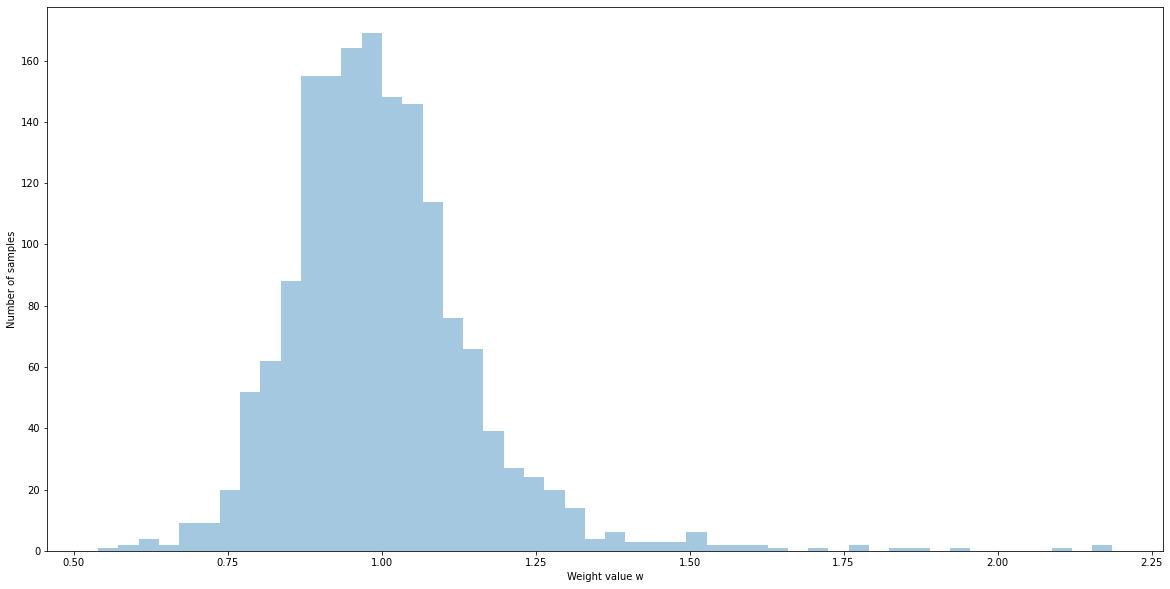

In [12]:
data_tests = data.head(1607)
data_tests = data_tests.drop(["is_ultra"], axis = 1)
dataa = data.loc[1607:].reset_index()
dataa = dataa.drop(["index"], axis = 1)

#create an indicator of belonging to the training sample (0 - does not belong, 1 - belongs)
data_tests["is_train"] = 0
dataa["is_train"] = 1

#union of samples train, test
df_combine = pd.concat([dataa, data_tests], axis=0, ignore_index=True)
#remove target label
df_combine = df_combine.drop('is_ultra', axis =1)

y = df_combine['is_train'].values #source indicator
x = df_combine.drop('is_train', axis=1).values #combined dataset

tst, trn = data_test.values, dataa.values

#Set up RandomForestClassifier to predict data source labels in the combined dataset
rfc = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5)
predictions = np.zeros(y.shape)#create an empty data array for class probabilities

#Divide the data into 4 samples, for each sample we will train the classifier on the larger part of the partition and predict the class label for the smaller, delayed part
from sklearn.model_selection import StratifiedKFold, cross_val_score
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=100)
for fold, (train_idx, test_idx) in enumerate(skf.split(x, y)):
    X_train, X_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
 
    rfc.fit(X_train, y_train)
    probs = rfc.predict_proba(X_test)[:, 1] #class probabilities prediction
    predictions[test_idx] = probs
#Probability of covariant shift
from sklearn.metrics import roc_auc_score
print('ROC-AUC:', roc_auc_score(y_true=y, y_score=predictions))
    
# Calculate the coefficient that will tell us how close the object from the training sample is to the test data
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
predictions_train = predictions[:len(trn)] 
weights = (1./predictions_train) - 1. 
weights /= np.mean(weights) #Normalization of weights

plt.xlabel('Weight value w')
plt.ylabel('Number of samples')
sns.distplot(weights, kde=False)

features_trains = dataa.drop(["is_ultra"], axis = 1)
target_trains = dataa["is_ultra"]

#Create a model using the hyperparameter values obtained as a result of using RandomizedSearchCV
rfc2 = RandomForestClassifier(n_jobs = -1, max_depth = 997, bootstrap = True, n_estimators = 863, min_samples_leaf = 12,
                             min_samples_split = 42, max_leaf_nodes = 374, random_state = 12345)
rfc2.fit(features_trains, target_trains, sample_weight = weights)
predictions = rfc2.predict(features_trains)
print("Model accuracy on training data:", accuracy_score(target_trains, predictions))

## Validate the model on the test set

In [13]:
predictions = model.predict(features_valid)
#features_valid["is_ultra"] = predictions
print("Model accuracy without using weighted weights on the validation set:", accuracy_score(target_valid, predictions))
features_test["is_train"] = 0
features_valid["is_train"] = 0
print("Model accuracy using weighted weights on the validation set:", accuracy_score(target_valid, rfc2.predict(features_valid)))
features_test["is_ultra"] = rfc2.predict(features_test)
print(features_test)

Model accuracy without using weighted weights on the validation set: 0.7978227060653188
Model accuracy using weighted weights on the validation set: 0.8133748055987559
      minutes  messages  mb_used  is_train  is_ultra
1386      537        18    20194         0         0
3124      287        17    17919         0         0
1956      531        56    17755         0         0
2286      461        27    16626         0         0
3077      120        16     9040         0         0
...       ...       ...      ...       ...       ...
1999      398         4    23683         0         0
1023      601         0    17104         0         0
748       526        15    18879         0         0
1667       63         0     2568         0         0
3197      661        68    11712         0         0

[643 rows x 5 columns]


# Conclusion

As expected, the use of the weighted weighting method was beneficial, the accuracy of the model with this method is 81.5 percent, while the model without this method is 80 percent.

In [14]:
#Проверим модель на адекватность.
from sklearn.dummy import DummyClassifier
strategies = ["most_frequent"]

dummy_results = []
for strategy in strategies:
    dc = DummyClassifier(strategy = strategy, random_state = 42)
    
dc.fit(features_train, target_train)

result = dc.score(features_valid, target_valid)
dummy_results.append({strategy: result})
pd.DataFrame(dummy_results)

,most_frequent
0,0.684292
